<a href="https://colab.research.google.com/github/gohigh19/EembeddedBoard/blob/master/Geographical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using 2673111 records with valid geographic coordinates
Creating hotspot map for: All Crime Hotspots with 2673111 records
Created crime hotspot map: crime_hotspot_all.html
Creating hotspot map for: Hotspots for: Controlled drugs with 1527572 records
Created crime hotspot map: crime_hotspot_Controlled_drugs.html
Creating hotspot map for: Hotspots for: Offensive weapons with 366276 records
Created crime hotspot map: crime_hotspot_Offensive_weapons.html
Creating hotspot map for: Hotspots for: Stolen goods with 250358 records
Created crime hotspot map: crime_hotspot_Stolen_goods.html
Creating hotspot map for: Hotspots for: Article for use in theft with 126599 records
Created crime hotspot map: crime_hotspot_Article_for_use_in_theft.html
Creating hotspot map for: Hotspots for: Evidence of offences under the Act with 59942 records
Created crime hotspot map: crime_hotspot_Evidence_of_offences_under_the_Act.html
Using 10 clusters for K-means


<ipython-input-1-d70dfd68acbe>:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['area_cluster'] = kmeans.predict(coords_scaled)


Performing K-means clustering with 10 clusters...


<ipython-input-1-d70dfd68acbe>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['area_cluster'] = kmeans.fit_predict(coords_scaled)
<ipython-input-1-d70dfd68acbe>:177: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


Created crime by area map and saved data to CSV
Created penalty analysis visualizations


<ipython-input-1-d70dfd68acbe>:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['area_cluster'] = kmeans_model.predict(coords_scaled)


Created interactive crime map
Geographic analysis completed successfully!


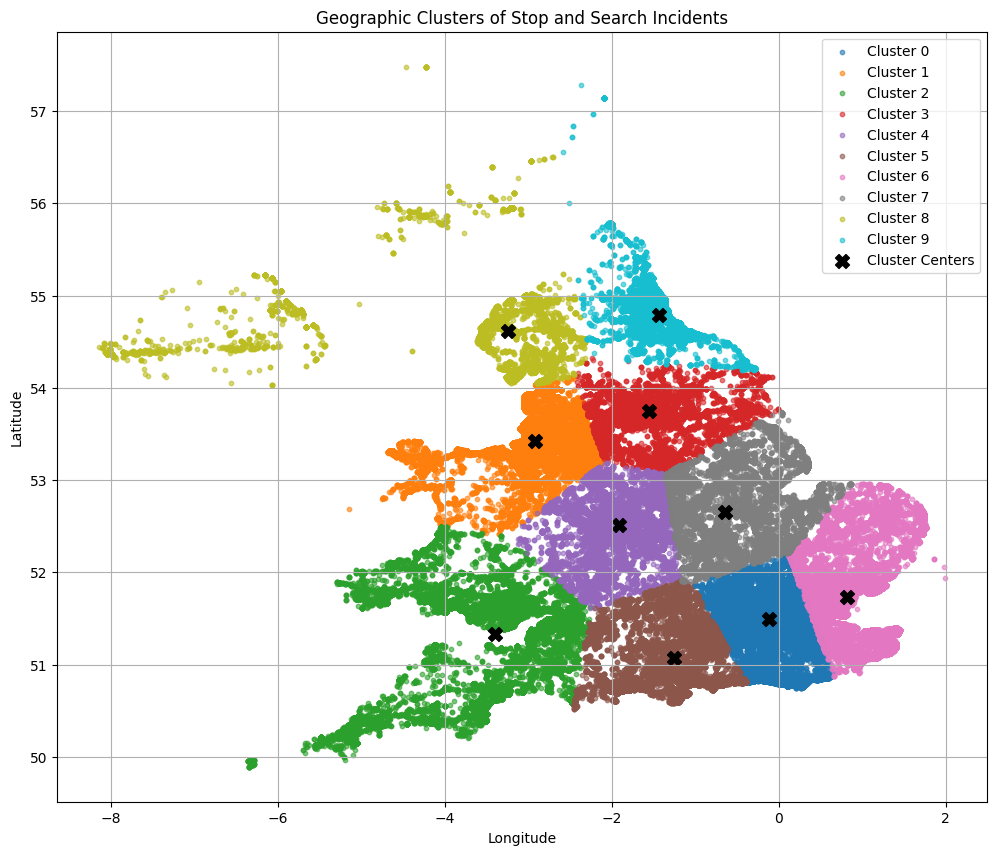

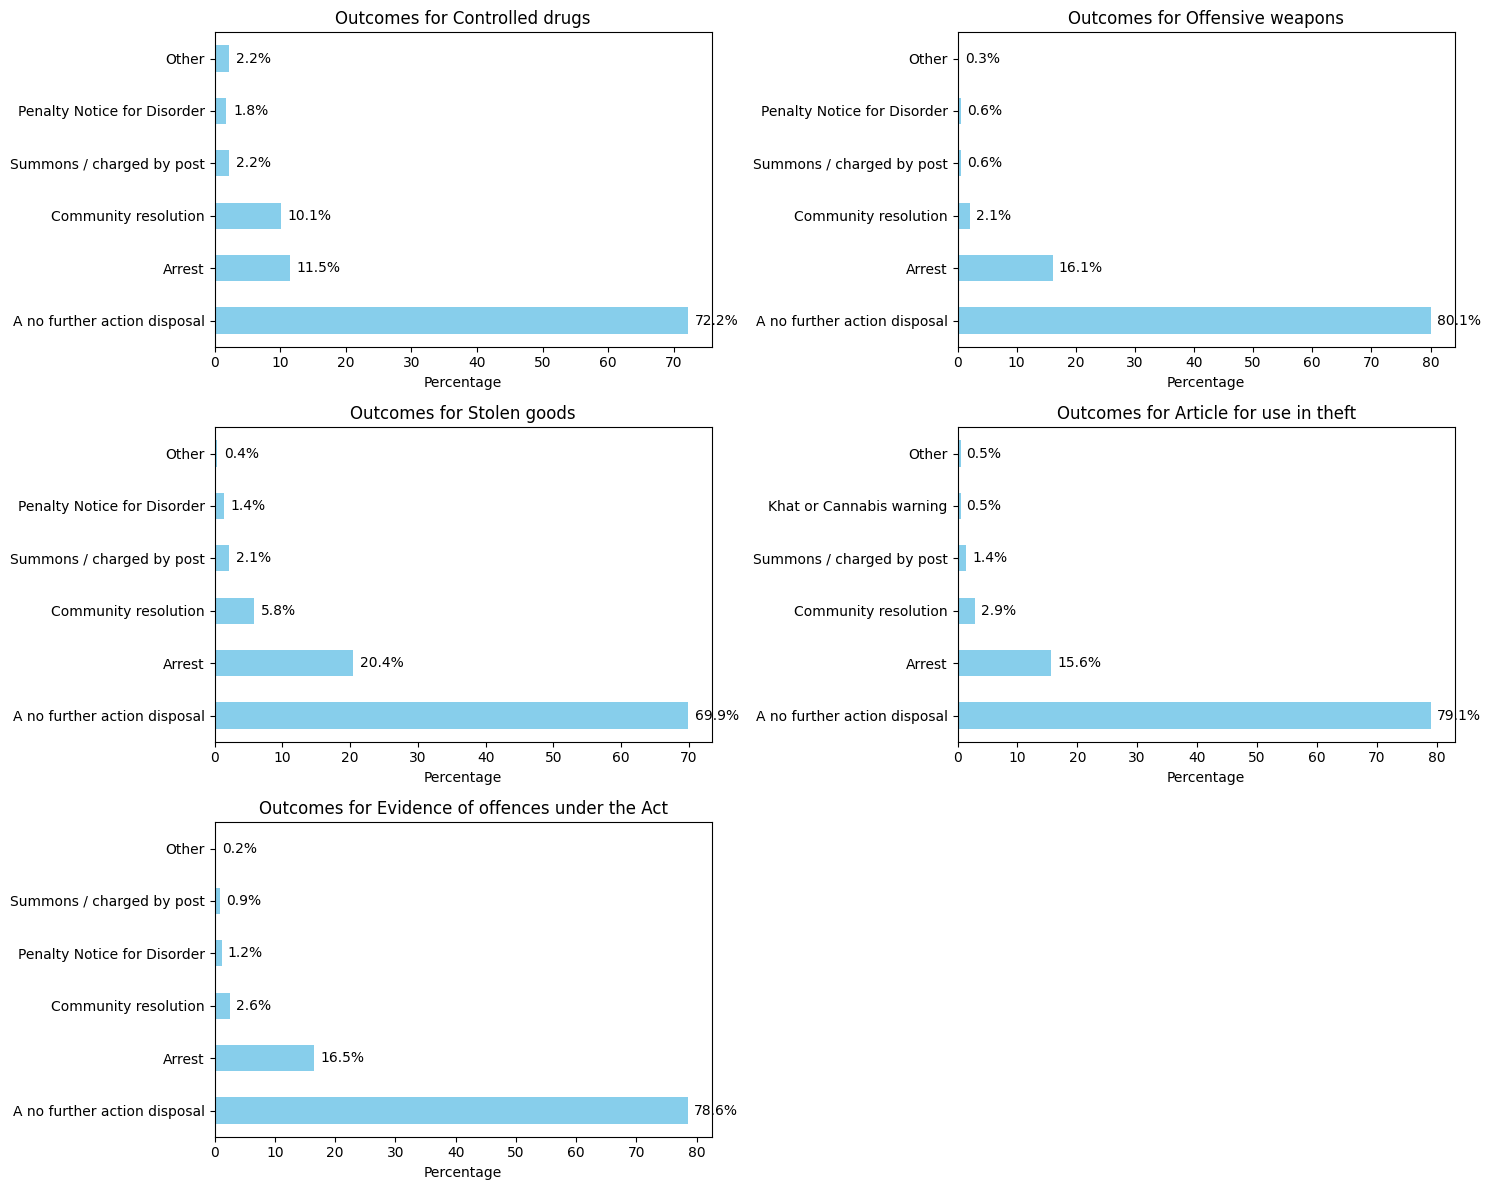

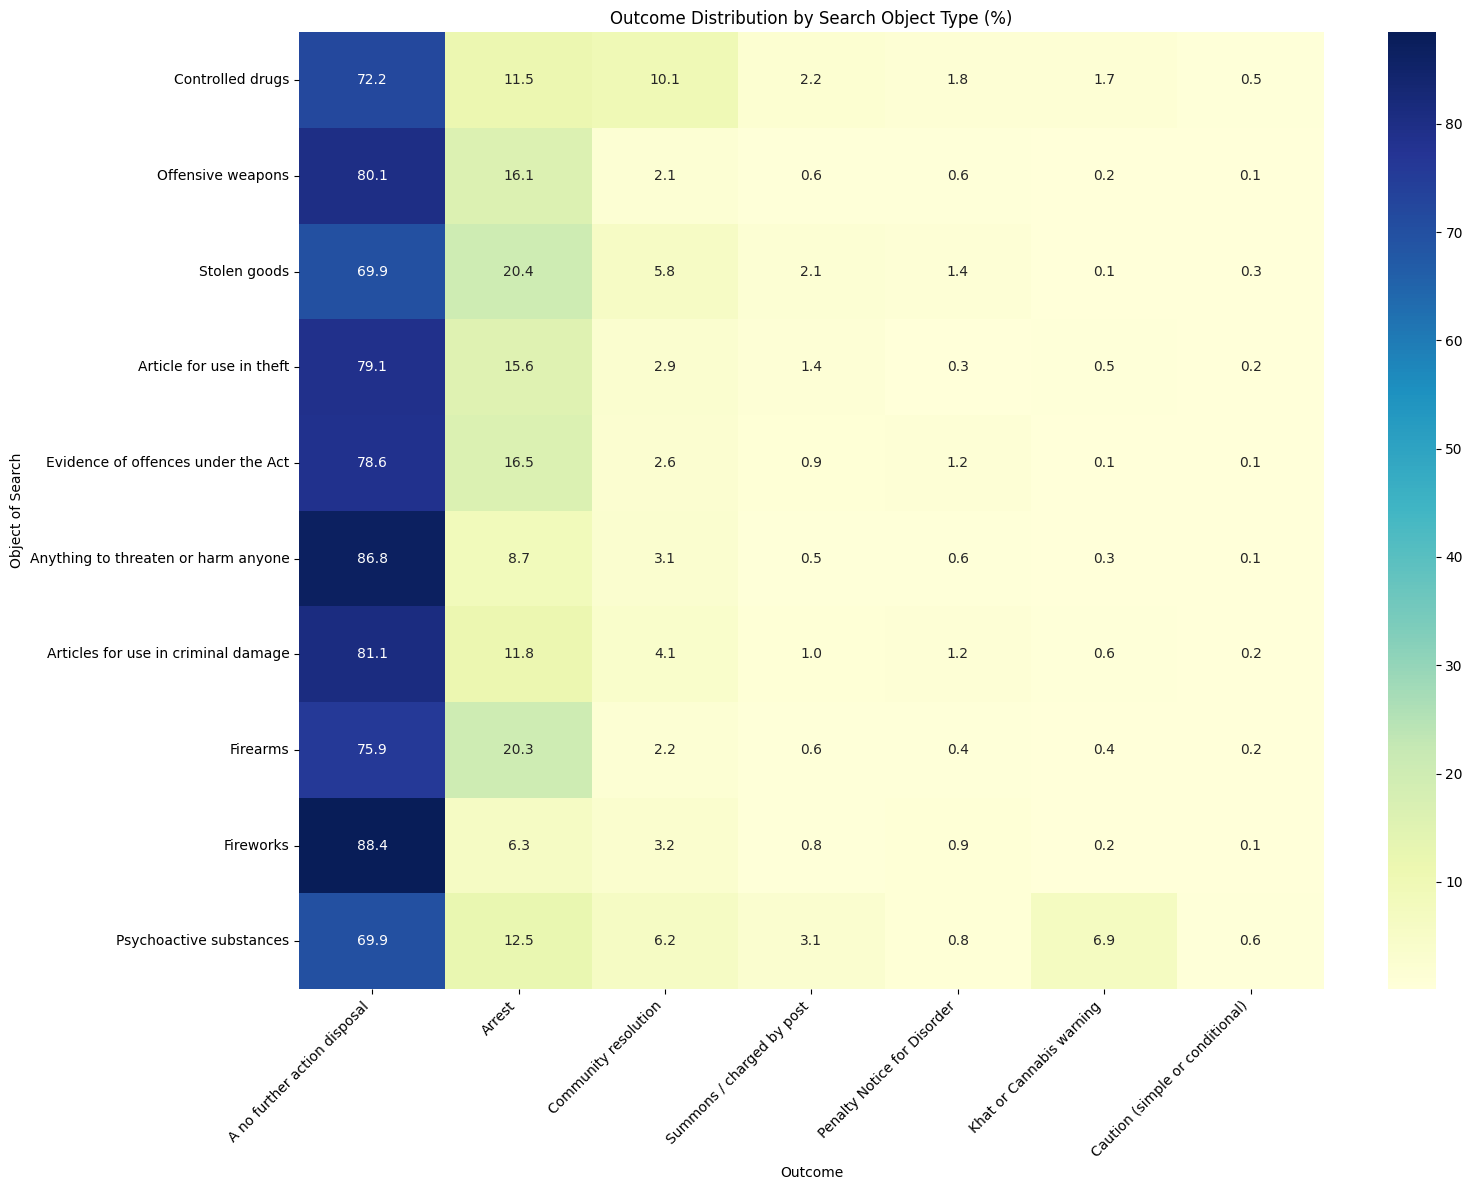

In [1]:
# Geographic Analysis Script with K-means Clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap, MarkerCluster
import joblib
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.colors import ListedColormap

# Load the data used for model training
base_path = '/content/drive/My Drive/Police Data AI/'
file_path = base_path + "combined_data_stop_and_search.csv"
df = pd.read_csv(file_path)

# Drop rows with missing coordinates
geo_df = df.dropna(subset=['Latitude', 'Longitude'])

print(f"Using {geo_df.shape[0]} records with valid geographic coordinates")

# === 1. Crime Hotspot Analysis ===
def analyze_crime_hotspots(data, crime_type=None):
    """
    Generate a heatmap showing where crimes happen most frequently

    Args:
        data: DataFrame with crime data
        crime_type: Optional filter for specific crime type
    """
    if crime_type:
        filtered_data = data[data['Object of search'] == crime_type]
        title = f"Hotspots for: {crime_type}"
    else:
        filtered_data = data
        title = "All Crime Hotspots"

    print(f"Creating hotspot map for: {title} with {filtered_data.shape[0]} records")

    # Create a map centered on the mean coordinates
    center_lat = filtered_data['Latitude'].mean()
    center_lon = filtered_data['Longitude'].mean()
    crime_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    # Add heatmap layer
    heat_data = [[row['Latitude'], row['Longitude']] for _, row in filtered_data.iterrows()]
    HeatMap(heat_data, radius=15).add_to(crime_map)

    # Add a title to the map
    folium.TileLayer(
        tiles='cartodbpositron',
        attr='CartoDB Positron'
    ).add_to(crime_map)

    # Save map
    map_title = f"crime_hotspot_{'all' if not crime_type else crime_type.replace(' ', '_')}.html"
    crime_map.save(base_path + map_title)

    print(f"Created crime hotspot map: {map_title}")
    return crime_map

# === 2. Area-specific Crime Analysis with K-means ===
def analyze_crimes_by_area_kmeans(data, n_clusters=10):
    """
    Identify which crimes are more prominent in which areas using K-means clustering

    Args:
        data: DataFrame with crime data
        n_clusters: Number of geographic clusters to create
    """
    print(f"Performing K-means clustering with {n_clusters} clusters...")

    # Extract coordinates for clustering
    coords = data[['Latitude', 'Longitude']].values

    # Scale coordinates for better clustering
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    # Apply K-means clustering to identify geographic areas
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    data['area_cluster'] = kmeans.fit_predict(coords_scaled)

    # Get cluster centers in original coordinate space
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Calculate crime type frequencies for each cluster
    area_crime_counts = pd.crosstab(
        data['area_cluster'],
        data['Object of search']
    )

    # Find the most common crime for each area
    area_summary = {}
    for cluster in range(n_clusters):
        # Get cluster center
        center_lat, center_lon = cluster_centers[cluster]

        # Find most common crime in this cluster
        crime_counts = area_crime_counts.loc[cluster]
        most_common_crime = crime_counts.idxmax()
        crime_count = crime_counts[most_common_crime]
        total_crimes = crime_counts.sum()
        percentage = (crime_count / total_crimes) * 100

        area_summary[cluster] = {
            'center': (center_lat, center_lon),
            'most_common_crime': most_common_crime,
            'percentage': percentage,
            'total_crimes': total_crimes
        }

    # Create a map showing the most common crime in each area
    crime_area_map = folium.Map(
        location=[data['Latitude'].mean(), data['Longitude'].mean()],
        zoom_start=9
    )

    # Create a color map for different crime types
    crime_types = list(set(info['most_common_crime'] for info in area_summary.values()))
    color_map = {}
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige',
              'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen']

    for i, crime in enumerate(crime_types):
        color_map[crime] = colors[i % len(colors)]

    # Add markers for each area with most common crime
    for cluster, info in area_summary.items():
        crime = info['most_common_crime']
        popup_text = f"""
        <b>Area ID:</b> {cluster}<br>
        <b>Most common crime:</b> {crime}<br>
        <b>Percentage:</b> {info['percentage']:.1f}%<br>
        <b>Total crimes:</b> {info['total_crimes']}
        """
        folium.CircleMarker(
            location=info['center'],
            popup=folium.Popup(popup_text, max_width=300),
            color=color_map[crime],
            fill=True,
            fill_opacity=0.7,
            radius=50 * (info['percentage']/100),  # Size proportional to percentage
        ).add_to(crime_area_map)

    # Add a legend (as a custom HTML element)
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000;
    background-color: white; padding: 10px; border: 2px solid grey; border-radius: 5px">
    <h4>Most Common Crime Type</h4>
    '''

    for crime, color in color_map.items():
        legend_html += f'''
        <div>
            <span style="background-color: {color}; display: inline-block; width: 20px; height: 20px; border-radius: 50%;"></span>
            <span style="margin-left: 5px;">{crime}</span>
        </div>
        '''

    legend_html += '</div>'

    crime_area_map.get_root().html.add_child(folium.Element(legend_html))

    # Save map
    crime_area_map.save(base_path + 'crime_by_area_kmeans.html')

    # Also save the tabular data
    area_crime_df = pd.DataFrame.from_dict(area_summary, orient='index')
    area_crime_df.to_csv(base_path + 'crime_by_area_kmeans.csv')

    # Create a scatter plot of the clusters on a map
    plt.figure(figsize=(12, 10))

    # Create a color map for visualization
    cmap = plt.cm.get_cmap('tab10', n_clusters)

    # Plot each cluster with a different color
    for cluster in range(n_clusters):
        cluster_data = data[data['area_cluster'] == cluster]
        plt.scatter(
            cluster_data['Longitude'],
            cluster_data['Latitude'],
            c=[cmap(cluster)],
            alpha=0.6,
            s=10,
            label=f"Cluster {cluster}"
        )

    # Plot cluster centers
    plt.scatter(
        cluster_centers[:, 1],  # Longitude is second column
        cluster_centers[:, 0],  # Latitude is first column
        c='black',
        marker='X',
        s=100,
        label='Cluster Centers'
    )

    plt.title('Geographic Clusters of Stop and Search Incidents')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(base_path + 'geographic_clusters.png', dpi=300, bbox_inches='tight')

    print(f"Created crime by area map and saved data to CSV")
    return area_crime_df

# === 3. Penalty Analysis by Crime Type ===
def analyze_penalties_by_crime(data):
    """
    Analyze the distribution of outcomes/penalties for each crime type
    """
    # Cross-tabulate object of search vs outcome
    penalty_distribution = pd.crosstab(
        data['Object of search'],
        data['Outcome'],
        normalize='index'
    ) * 100

    # Format as percentage
    penalty_distribution = penalty_distribution.round(1)

    # Save to CSV
    penalty_distribution.to_csv(base_path + 'penalty_distribution.csv')

    # Create visualizations for the top 5 most common crimes
    top_crimes = data['Object of search'].value_counts().head(5).index

    plt.figure(figsize=(15, 12))
    for i, crime in enumerate(top_crimes):
        plt.subplot(3, 2, i+1)

        # Sort by percentage for better visualization
        sorted_data = penalty_distribution.loc[crime].sort_values(ascending=False)

        # Only show top 5 outcomes for clarity
        if len(sorted_data) > 5:
            top_outcomes = sorted_data.head(5)
            other_sum = sorted_data[5:].sum()
            data_to_plot = pd.concat([top_outcomes, pd.Series({'Other': other_sum})])
        else:
            data_to_plot = sorted_data

        # Plot as horizontal bar for better label readability
        ax = data_to_plot.plot(kind='barh', color='skyblue')
        ax.set_xlabel('Percentage')
        ax.set_title(f'Outcomes for {crime}')

        # Add percentage labels
        for i, v in enumerate(data_to_plot):
            ax.text(v + 1, i, f"{v:.1f}%", va='center')

    plt.tight_layout()
    plt.savefig(base_path + 'penalty_analysis.png')

    # Also create a heatmap for a comprehensive view
    plt.figure(figsize=(16, 12))

    # Select top 10 crimes and top 10 outcomes for readability
    top10_crimes = data['Object of search'].value_counts().head(10).index
    top10_outcomes = data['Outcome'].value_counts().head(10).index

    # Filter the crosstab for top crimes and outcomes
    heatmap_data = pd.crosstab(
        data['Object of search'],
        data['Outcome'],
        normalize='index'
    ) * 100

    heatmap_data = heatmap_data.loc[top10_crimes, top10_outcomes]

    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt='.1f')
    plt.title('Outcome Distribution by Search Object Type (%)')
    plt.xlabel('Outcome')
    plt.ylabel('Object of Search')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(base_path + 'outcome_heatmap.png')

    print(f"Created penalty analysis visualizations")
    return penalty_distribution

# === 4. Interactive Map with Areas and Crime Analysis ===
def create_interactive_map(data, kmeans_model, n_clusters=10):
    """
    Creates an interactive map showing clusters and crime distributions
    """
    # Get unique crime types for color coding
    crime_types = data['Object of search'].unique()

    # Create a map centered on the mean coordinates
    center_lat = data['Latitude'].mean()
    center_lon = data['Longitude'].mean()
    interactive_map = folium.Map(location=[center_lat, center_lon], zoom_start=9)

    # Create marker clusters for each crime type
    crime_markers = {}
    for crime in crime_types:
        crime_markers[crime] = MarkerCluster(name=f"Search for: {crime}").add_to(interactive_map)

    # Add data points with popup information
    for _, row in data.sample(min(5000, len(data))).iterrows():  # Sample to prevent browser slowdown
        popup_text = f"""
        <b>Type:</b> {row['Type']}<br>
        <b>Object of search:</b> {row['Object of search']}<br>
        <b>Outcome:</b> {row['Outcome']}<br>
        <b>Gender:</b> {row['Gender']}<br>
        <b>Age range:</b> {row['Age range']}<br>
        <b>Cluster:</b> {row['area_cluster']}
        """

        # Add to appropriate crime type marker cluster
        crime_type = row['Object of search']
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(icon='info-sign')
        ).add_to(crime_markers.get(crime_type, interactive_map))

    # Add cluster boundaries
    coords = data[['Latitude', 'Longitude']].values
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    # Get cluster assignments
    data['area_cluster'] = kmeans_model.predict(coords_scaled)

    # Get cluster centers in original coordinate space
    cluster_centers = scaler.inverse_transform(kmeans_model.cluster_centers_)

    # Add cluster circles
    for i, center in enumerate(cluster_centers):
        # Count incidents in this cluster
        cluster_size = sum(data['area_cluster'] == i)

        # Get most common crime in this cluster
        cluster_data = data[data['area_cluster'] == i]
        if len(cluster_data) > 0:
            most_common = cluster_data['Object of search'].value_counts().idxmax()
            tooltip = f"Cluster {i}: {most_common} ({cluster_size} incidents)"
        else:
            tooltip = f"Cluster {i}: {cluster_size} incidents"

        # Add circle marking the cluster
        folium.Circle(
            location=[center[0], center[1]],
            radius=2000,  # 2km radius
            color='red',
            fill=True,
            fill_opacity=0.2,
            tooltip=tooltip
        ).add_to(interactive_map)

    # Add layer control
    folium.LayerControl().add_to(interactive_map)

    # Save map
    interactive_map.save(base_path + 'interactive_crime_map.html')
    print("Created interactive crime map")

# Run all analyses
try:
    # Overall crime hotspots
    analyze_crime_hotspots(geo_df)

    # Create hotspots for the 5 most common crimes
    top_crimes = geo_df['Object of search'].value_counts().head(5).index
    for crime in top_crimes:
        analyze_crime_hotspots(geo_df, crime)

    # Area-specific crime analysis using K-means
    # Determine optimal number of clusters
    n_clusters = min(10, len(geo_df) // 1000)  # Adjust based on data size
    print(f"Using {n_clusters} clusters for K-means")

    # Run K-means for area analysis
    coords = geo_df[['Latitude', 'Longitude']].values
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(coords_scaled)
    geo_df['area_cluster'] = kmeans.predict(coords_scaled)

    # Save the K-means model
    joblib.dump(kmeans, base_path + 'kmeans_model.pkl')
    joblib.dump(scaler, base_path + 'geo_scaler.pkl')

    # Run the area analysis
    area_crime_data = analyze_crimes_by_area_kmeans(geo_df, n_clusters)

    # Penalty analysis
    penalty_data = analyze_penalties_by_crime(df)

    # Create interactive map
    create_interactive_map(geo_df, kmeans, n_clusters)

    print("Geographic analysis completed successfully!")

except Exception as e:
    print(f"Error during geographic analysis: {e}")

Using 2673111 records with location data
Creating hotspot map for: All Crime Hotspots with 2673111 records
Created crime hotspot map: crime_hotspot_all.html
Creating hotspot map for: Hotspots for: Controlled drugs with 1527572 records
Created crime hotspot map: crime_hotspot_Controlled_drugs.html
Creating hotspot map for: Hotspots for: Offensive weapons with 366276 records
Created crime hotspot map: crime_hotspot_Offensive_weapons.html
Creating hotspot map for: Hotspots for: Stolen goods with 250358 records
Created crime hotspot map: crime_hotspot_Stolen_goods.html
Creating hotspot map for: Hotspots for: Article for use in theft with 126599 records
Created crime hotspot map: crime_hotspot_Article_for_use_in_theft.html
Creating hotspot map for: Hotspots for: Evidence of offences under the Act with 59942 records
Created crime hotspot map: crime_hotspot_Evidence_of_offences_under_the_Act.html
Using 10 clusters for K-means
Finding 10 crime areas...


<ipython-input-2-b344c5d8267b>:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


Created crime by area map and saved data to CSV
Created penalty analysis visualizations
Created interactive crime map
Geographic analysis completed successfully!


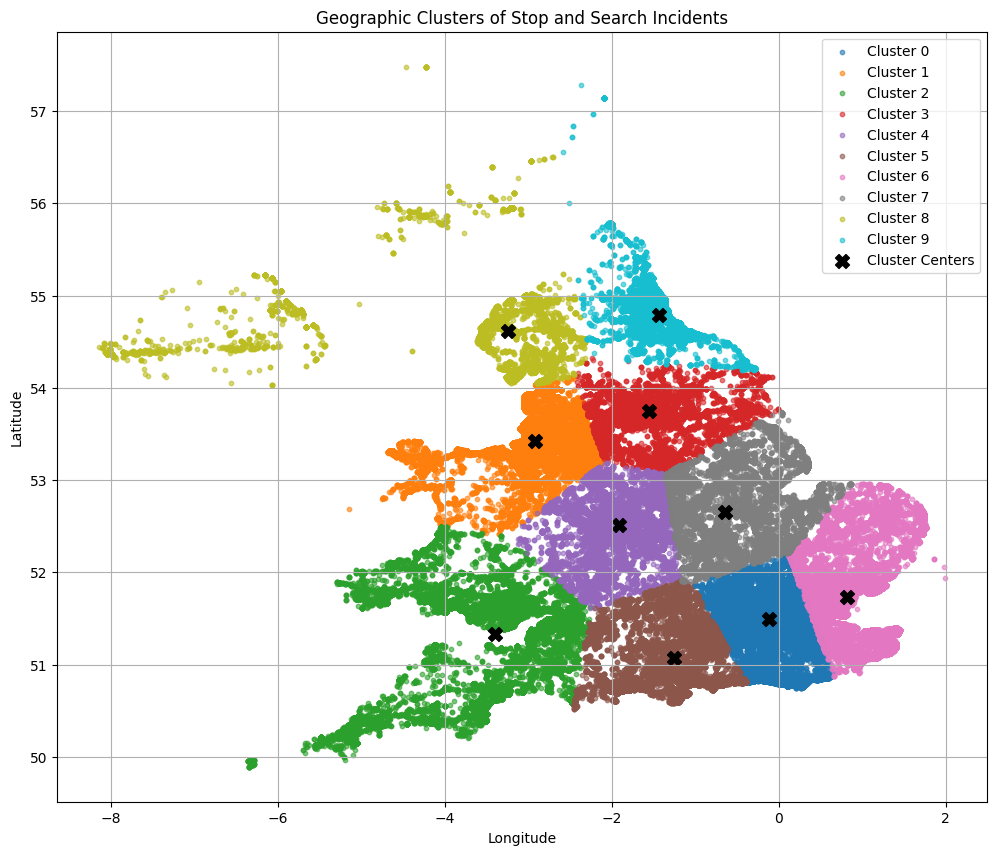

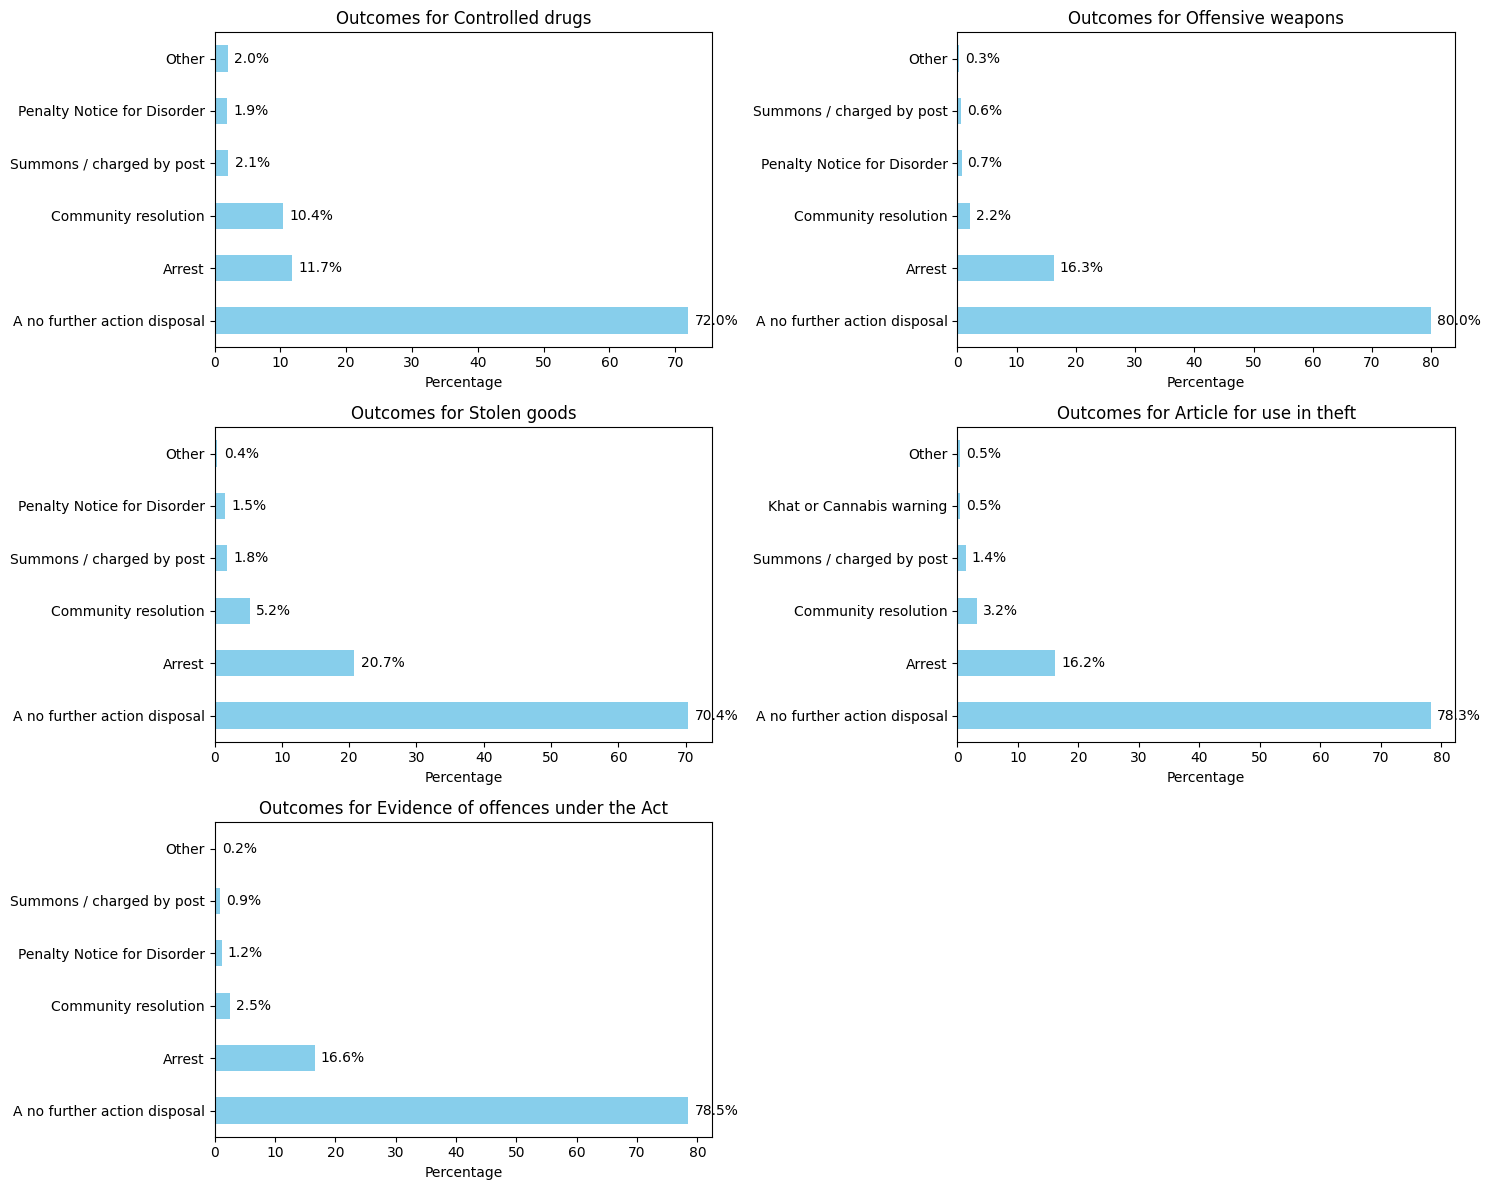

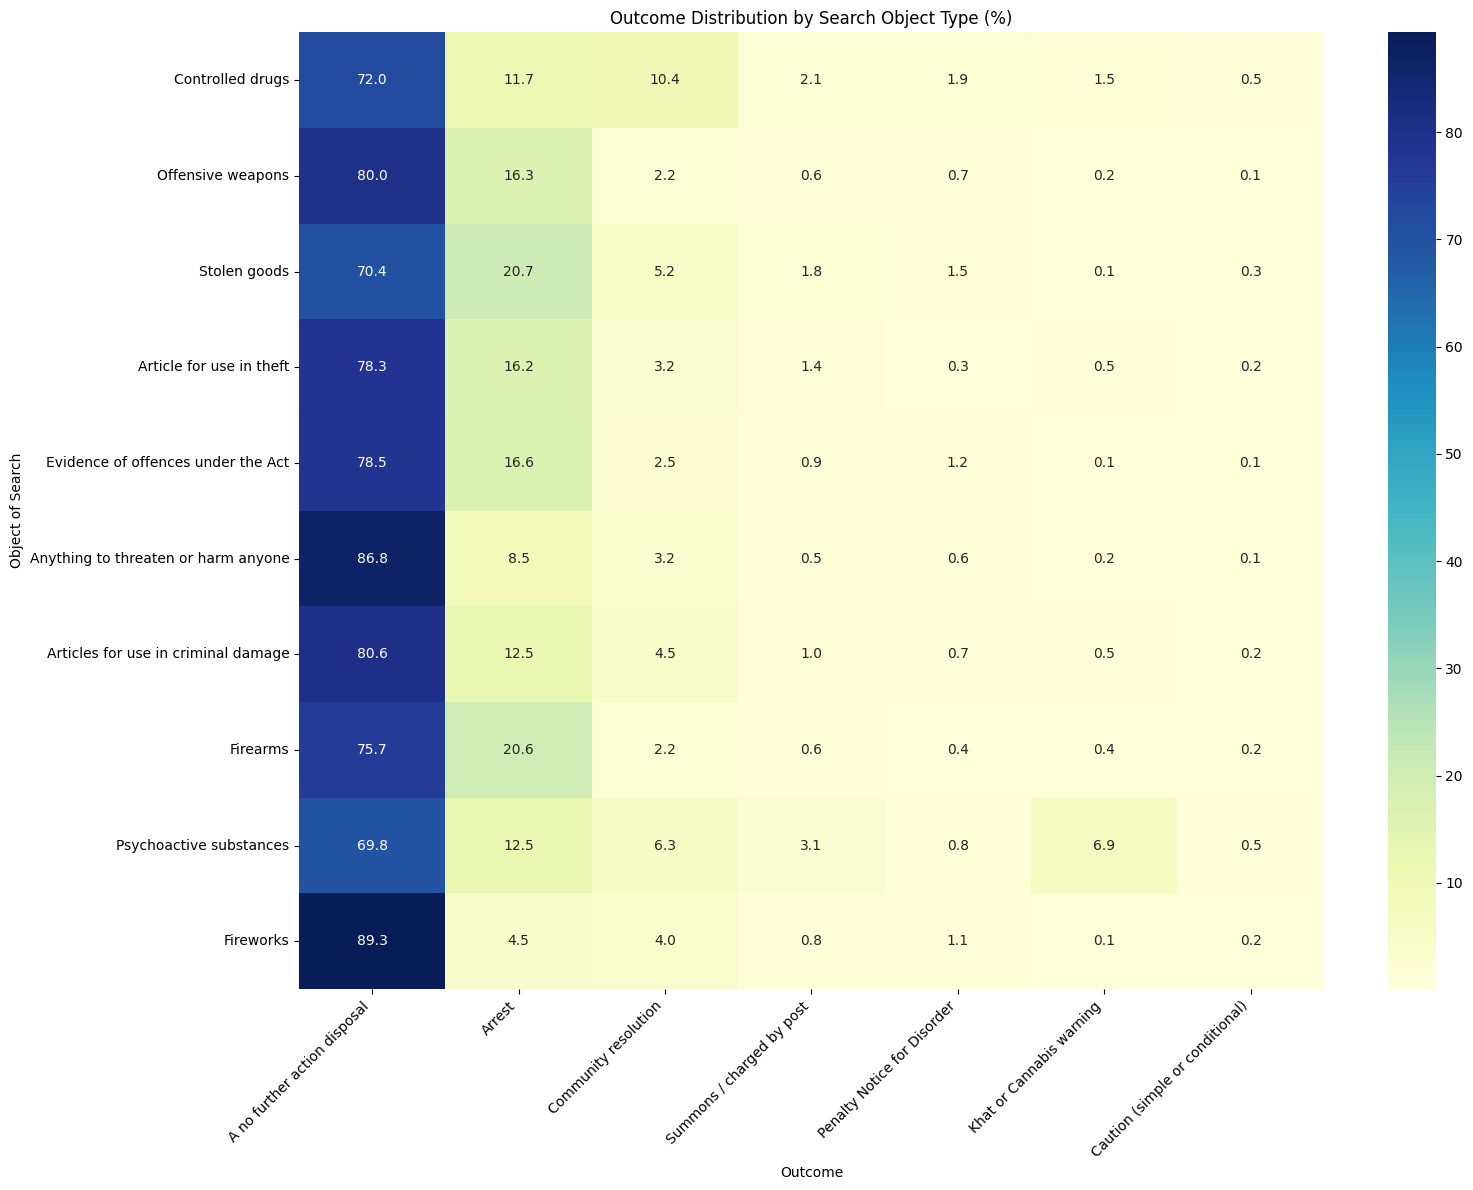

In [2]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
BASE_PATH = '/content/drive/My Drive/Police Data AI/'  # Where your files are
DATA_FILE = BASE_PATH + "combined_data_stop_and_search.csv"  # Your data file
N_CLUSTERS = 10  # How many crime areas to find

# --- 1. Load and Prepare Data ---
def load_and_clean_data(file_path):
    """Loads the data and removes entries with missing location information."""
    df = pd.read_csv(file_path)
    geo_df = df.dropna(subset=['Latitude', 'Longitude'])
    print(f"Using {geo_df.shape[0]} records with location data")
    return geo_df

# --- 2. Crime Hotspot Maps ---
def create_hotspot_map(data, crime_type=None):
    """
    Creates a heatmap showing crime frequency.

    Args:
        data: DataFrame with crime data.
        crime_type: Optional filter for a specific crime.
    """
    if crime_type:
        filtered_data = data[data['Object of search'] == crime_type]
        title = f"Hotspots for: {crime_type}"
    else:
        filtered_data = data
        title = "All Crime Hotspots"

    print(f"Creating hotspot map for: {title} with {filtered_data.shape[0]} records")

    # Center the map
    center_lat = filtered_data['Latitude'].mean()
    center_lon = filtered_data['Longitude'].mean()
    crime_map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

    # Add the heatmap
    heat_data = [[row['Latitude'], row['Longitude']] for _, row in filtered_data.iterrows()]
    HeatMap(heat_data, radius=15).add_to(crime_map)

    # Add a title to the map
    folium.TileLayer(
        tiles='cartodbpositron',
        attr='CartoDB Positron'
    ).add_to(crime_map)

    # Save the map
    map_title = f"crime_hotspot_{'all' if not crime_type else crime_type.replace(' ', '_')}.html"
    crime_map.save(BASE_PATH + map_title)
    print(f"Created crime hotspot map: {map_title}")
    return crime_map

# --- 3. Crime Areas with K-Means Clustering ---
def analyze_crime_areas(data, n_clusters):
    """
    Identifies crime areas using K-means clustering.

    Args:
        data: DataFrame with crime data.
        n_clusters: Number of crime areas to find.
    """
    print(f"Finding {n_clusters} crime areas...")

    # Prepare coordinates for clustering
    coords = data[['Latitude', 'Longitude']].values
    scaler = StandardScaler()  # Scale the coordinates
    coords_scaled = scaler.fit_transform(coords)

    # Cluster the coordinates
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    data['area_cluster'] = kmeans.fit_predict(coords_scaled)

    # Save the clustering model and scaler
    joblib.dump(kmeans, BASE_PATH + 'kmeans_model.pkl')
    joblib.dump(scaler, BASE_PATH + 'geo_scaler.pkl')

    # Analyze crimes within each area
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    area_crime_counts = pd.crosstab(data['area_cluster'], data['Object of search'])

    area_summary = {}
    for cluster in range(n_clusters):
        center_lat, center_lon = cluster_centers[cluster]
        crime_counts = area_crime_counts.loc[cluster]
        most_common_crime = crime_counts.idxmax()
        crime_count = crime_counts[most_common_crime]
        total_crimes = crime_counts.sum()
        percentage = (crime_count / total_crimes) * 100

        area_summary[cluster] = {
            'center': (center_lat, center_lon),
            'most_common_crime': most_common_crime,
            'percentage': percentage,
            'total_crimes': total_crimes
        }

    # Create a map showing crime areas
    crime_area_map = folium.Map(
        location=[data['Latitude'].mean(), data['Longitude'].mean()],
        zoom_start=9
    )

    # Add markers for each area with the most common crime
    crime_colors = {}
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige',
              'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen']

    crime_types = list(set(info['most_common_crime'] for info in area_summary.values()))

    for i, crime in enumerate(crime_types):
        crime_colors[crime] = colors[i % len(colors)]

    for cluster, info in area_summary.items():
        crime = info['most_common_crime']
        popup_text = f"""
        <b>Area ID:</b> {cluster}<br>
        <b>Most common crime:</b> {crime}<br>
        <b>Percentage:</b> {info['percentage']:.1f}%<br>
        <b>Total crimes:</b> {info['total_crimes']}
        """
        folium.CircleMarker(
            location=info['center'],
            popup=folium.Popup(popup_text, max_width=300),
            color=crime_colors[crime],
            fill=True,
            fill_opacity=0.7,
            radius=50 * (info['percentage'] / 100),  # Size proportional to percentage
        ).add_to(crime_area_map)

    # Add a legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000;
    background-color: white; padding: 10px; border: 2px solid grey; border-radius: 5px">
    <h4>Most Common Crime Type</h4>
    '''

    for crime, color in crime_colors.items():
        legend_html += f'''
        <div>
            <span style="background-color: {color}; display: inline-block; width: 20px; height: 20px; border-radius: 50%;"></span>
            <span style="margin-left: 5px;">{crime}</span>
        </div>
        '''

    legend_html += '</div>'
    crime_area_map.get_root().html.add_child(folium.Element(legend_html))

    # Save the map and the data
    crime_area_map.save(BASE_PATH + 'crime_by_area_kmeans.html')
    area_crime_df = pd.DataFrame.from_dict(area_summary, orient='index')
    area_crime_df.to_csv(BASE_PATH + 'crime_by_area_kmeans.csv')

    # Create a scatter plot of the clusters
    plt.figure(figsize=(12, 10))
    cmap = plt.cm.get_cmap('tab10', n_clusters)

    for cluster in range(n_clusters):
        cluster_data = data[data['area_cluster'] == cluster]
        plt.scatter(
            cluster_data['Longitude'],
            cluster_data['Latitude'],
            c=[cmap(cluster)],
            alpha=0.6,
            s=10,
            label=f"Cluster {cluster}"
        )

    plt.scatter(
        cluster_centers[:, 1],  # Longitude
        cluster_centers[:, 0],  # Latitude
        c='black',
        marker='X',
        s=100,
        label='Cluster Centers'
    )

    plt.title('Geographic Clusters of Stop and Search Incidents')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig(BASE_PATH + 'geographic_clusters.png', dpi=300, bbox_inches='tight')

    print("Created crime by area map and saved data to CSV")
    return area_crime_df

# --- 4. Outcome Analysis ---
def analyze_outcomes(data):
    """
    Analyzes the outcomes of stop and search incidents.

    Args:
        data: DataFrame with crime data.
    """
    # Cross-tabulate object of search vs outcome
    penalty_distribution = pd.crosstab(
        data['Object of search'],
        data['Outcome'],
        normalize='index'
    ) * 100

    # Format as percentage
    penalty_distribution = penalty_distribution.round(1)

    # Save to CSV
    penalty_distribution.to_csv(BASE_PATH + 'penalty_distribution.csv')

    # Create visualizations for the top 5 most common crimes
    top_crimes = data['Object of search'].value_counts().head(5).index

    plt.figure(figsize=(15, 12))
    for i, crime in enumerate(top_crimes):
        plt.subplot(3, 2, i + 1)

        # Sort by percentage for better visualization
        sorted_data = penalty_distribution.loc[crime].sort_values(ascending=False)

        # Only show top 5 outcomes for clarity
        if len(sorted_data) > 5:
            top_outcomes = sorted_data.head(5)
            other_sum = sorted_data[5:].sum()
            data_to_plot = pd.concat([top_outcomes, pd.Series({'Other': other_sum})])
        else:
            data_to_plot = sorted_data

        # Plot as horizontal bar for better label readability
        ax = data_to_plot.plot(kind='barh', color='skyblue')
        ax.set_xlabel('Percentage')
        ax.set_title(f'Outcomes for {crime}')

        # Add percentage labels
        for i, v in enumerate(data_to_plot):
            ax.text(v + 1, i, f"{v:.1f}%", va='center')

    plt.tight_layout()
    plt.savefig(BASE_PATH + 'penalty_analysis.png')

    # Also create a heatmap for a comprehensive view
    plt.figure(figsize=(16, 12))

    # Select top 10 crimes and top 10 outcomes for readability
    top10_crimes = data['Object of search'].value_counts().head(10).index
    top10_outcomes = data['Outcome'].value_counts().head(10).index

    # Filter the crosstab for top crimes and outcomes
    heatmap_data = pd.crosstab(
        data['Object of search'],
        data['Outcome'],
        normalize='index'
    ) * 100

    heatmap_data = heatmap_data.loc[top10_crimes, top10_outcomes]

    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt='.1f')
    plt.title('Outcome Distribution by Search Object Type (%)')
    plt.xlabel('Outcome')
    plt.ylabel('Object of Search')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(BASE_PATH + 'outcome_heatmap.png')

    print("Created penalty analysis visualizations")
    return penalty_distribution

# --- 5. Interactive Crime Map ---
def create_interactive_crime_map(data, kmeans_model, n_clusters):
    """
    Creates an interactive map showing crime locations and clusters.

    Args:
        data: DataFrame with crime data.
        kmeans_model: Trained K-means model.
        n_clusters: Number of clusters.
    """
    # Get unique crime types for color coding
    crime_types = data['Object of search'].unique()

    # Create a map centered on the mean coordinates
    center_lat = data['Latitude'].mean()
    center_lon = data['Longitude'].mean()
    interactive_map = folium.Map(location=[center_lat, center_lon], zoom_start=9)

    # Create marker clusters for each crime type
    crime_markers = {}
    for crime in crime_types:
        crime_markers[crime] = MarkerCluster(name=f"Search for: {crime}").add_to(interactive_map)

    # Add data points with popup information
    for _, row in data.sample(min(5000, len(data))).iterrows():  # Sample to prevent browser slowdown
        popup_text = f"""
        <b>Type:</b> {row['Type']}<br>
        <b>Object of search:</b> {row['Object of search']}<br>
        <b>Outcome:</b> {row['Outcome']}<br>
        <b>Gender:</b> {row['Gender']}<br>
        <b>Age range:</b> {row['Age range']}<br>
        <b>Cluster:</b> {row['area_cluster']}
        """

        # Add to appropriate crime type marker cluster
        crime_type = row['Object of search']
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            icon=folium.Icon(icon='info-sign')
        ).add_to(crime_markers.get(crime_type, interactive_map))

    # Add cluster boundaries
    coords = data[['Latitude', 'Longitude']].values
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    # Get cluster assignments
    data['area_cluster'] = kmeans_model.predict(coords_scaled)

    # Get cluster centers in original coordinate space
    cluster_centers = scaler.inverse_transform(kmeans_model.cluster_centers_)

    # Add cluster circles
    for i, center in enumerate(cluster_centers):
        # Count incidents in this cluster
        cluster_size = sum(data['area_cluster'] == i)

        # Get most common crime in this cluster
        cluster_data = data[data['area_cluster'] == i]
        if len(cluster_data) > 0:
            most_common = cluster_data['Object of search'].value_counts().idxmax()
            tooltip = f"Cluster {i}: {most_common} ({cluster_size} incidents)"
        else:
            tooltip = f"Cluster {i}: {cluster_size} incidents"

        # Add circle marking the cluster
        folium.Circle(
            location=[center[0], center[1]],
            radius=2000,  # 2km radius
            color='red',
            fill=True,
            fill_opacity=0.2,
            tooltip=tooltip
        ).add_to(interactive_map)

    # Add layer control
    folium.LayerControl().add_to(interactive_map)

    # Save map
    interactive_map.save(BASE_PATH + 'interactive_crime_map.html')
    print("Created interactive crime map")

# --- Main Execution ---
if __name__ == "__main__":
    try:
        # 1. Load and clean data
        geo_df = load_and_clean_data(DATA_FILE)

        # 2. Overall crime hotspots
        create_hotspot_map(geo_df)

        # 3. Create hotspots for the 5 most common crimes
        top_crimes = geo_df['Object of search'].value_counts().head(5).index
        for crime in top_crimes:
            create_hotspot_map(geo_df, crime)

        # 4. Area-specific crime analysis using K-means
        n_clusters = min(N_CLUSTERS, len(geo_df) // 1000)  # Adjust based on data size
        print(f"Using {n_clusters} clusters for K-means")

        # Run K-means for area analysis
        coords = geo_df[['Latitude', 'Longitude']].values
        scaler = StandardScaler()
        coords_scaled = scaler.fit_transform(coords)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(coords_scaled)
        geo_df['area_cluster'] = kmeans.predict(coords_scaled)

        # Run the area analysis
        area_crime_data = analyze_crime_areas(geo_df, n_clusters)

        # 5. Outcome analysis
        penalty_data = analyze_outcomes(geo_df)

        # 6. Create interactive map
        create_interactive_crime_map(geo_df, kmeans, n_clusters)

        print("Geographic analysis completed successfully!")

    except Exception as e:
        print(f"Error during geographic analysis: {e}")